In [1]:
import pandas as pd
import numpy as np
from ScanImageTiffReader import ScanImageTiffReader
import os
import matplotlib.pyplot as plt
import scipy.signal
import tifffile
from scipy.signal import butter, lfilter,find_peaks, gaussian, convolve
from ibllib.io.video import *
import scipy.ndimage
import cv2
from matplotlib.animation import FuncAnimation, FFMpegWriter
from IPython.display import HTML
from matplotlib.animation import PillowWriter
from ScanImageTiffReader import ScanImageTiffReader
import json
from murphlib.caimage import *
from murphlib.tools import *
from murphlib.plotting import *
from murphlib.regression import *
from sklearn.decomposition import PCA
from sklearn.metrics import explained_variance_score
from scipy.stats import zscore
plt.rcParams['animation.ffmpeg_path'] = r'D:\ffmpeg\bin\ffmpeg.exe'

In [2]:
event_variable_names = ['vis_ruleCue_times','aud_ruleCue_times', 'left_vis_stimOn_times', 'right_vis_stimOn_times', 'left_aud_stimOn_times', 'right_aud_stimOn_times', 
                                'vis_reward_times', 'aud_reward_times', 'vis_punish_times', 'aud_punish_times', 'omission_times'] 
# event_variable_names = ['ruleCue_times', 'vis_stimOn_times',  'aud_stimOn_times',  
#                         'reward_times', 'punish_times', 'omission_times'] 
whole_variable_names = ['leftchoice', 'rightchoice', 'previous_feedbackType', 'reward_history']

In [ ]:
mouse_path = r'Z:\TM_Lab\Edward\Cerebellum_Imaging\Pcp2-jgcamp8m\J_L2'
dates = [

    #'20240815',
    #'20240821',
    # '20240904',
    # '20240910',
    # '20240918',
    # '20240924',
    #'20241015',
    # '20241018',
    #'20241106',
    # '20241111',
    # '20241115',
    '20241118',
    # '20241119'
]
for date in dates:
    session_path = os.path.join(mouse_path, date)
    bhv_path = os.path.join(session_path, 'behavior')
    # with open(os.path.join(bhv_path, 'raw_behavior_data','_iblrig_taskSettings.raw.json'), 'r') as json_file:
    #         tasksettings = json.load(json_file)
    facemap_folder = os.path.join(bhv_path, 'raw_video_data')
    try:
        pupil_area = np.load(os.path.join(facemap_folder, 'pupil_area.npy'))
        pupil_xpos = np.load(os.path.join(facemap_folder, 'pupil_xpos.npy'))
        pupil_ypos = np.load(os.path.join(facemap_folder, 'pupil_ypos.npy'))
        body_motion = np.load(os.path.join(facemap_folder, 'bodymotion_svd.npy'))
        face_motion = np.load(os.path.join(facemap_folder, 'facemotion_svd.npy'))
        lick = np.load(os.path.join(facemap_folder, 'lickmotion_svd.npy'))
    except:
        facemap_out = np.load(os.path.join(facemap_folder, '_iblrig_leftCamera.raw_proc.npy'), allow_pickle=True).item()
        np.save(os.path.join(facemap_folder, 'pupil_area'), facemap_out['pupil'][0]['area_smooth'])
        np.save(os.path.join(facemap_folder, 'pupil_xpos'), facemap_out['pupil'][0]['com'][:,0])
        np.save(os.path.join(facemap_folder, 'pupil_ypos'), facemap_out['pupil'][0]['com'][:,1])
        np.save(os.path.join(facemap_folder, 'bodymotion_svd'), facemap_out['motSVD'][1])
        np.save(os.path.join(facemap_folder, 'lickmotion_svd'), facemap_out['motSVD'][2])
        np.save(os.path.join(facemap_folder, 'facemotion_svd'), facemap_out['motSVD'][3])
        pupil_area = np.load(os.path.join(facemap_folder, 'pupil_area.npy'))
        pupil_xpos = np.load(os.path.join(facemap_folder, 'pupil_xpos.npy'))
        pupil_ypos = np.load(os.path.join(facemap_folder, 'pupil_ypos.npy'))
        body_motion = np.load(os.path.join(facemap_folder, 'bodymotion_svd.npy'))
        face_motion = np.load(os.path.join(facemap_folder, 'facemotion_svd.npy'))
        lick = np.load(os.path.join(facemap_folder, 'lickmotion_svd.npy'))

    pupil_area = fill_nan_with_previous(pupil_area)
    pupil_xpos = fill_nan_with_previous(pupil_xpos)
    pupil_ypos = fill_nan_with_previous(pupil_ypos)
    table_for_video = pd.read_csv(bhv_path+'\\table_for_video.csv')
    video_start = table_for_video['ruleCue_times'][0]
    video_end = table_for_video['intervals_1'].iloc[-1]
    pupil_area = pupil_area[video_start:video_end+1]
    pupil_xpos = pupil_xpos[video_start:video_end+1]
    pupil_ypos = pupil_ypos[video_start:video_end+1]
    body_motion = body_motion[video_start:video_end+1,:]
    lick = lick[video_start:video_end+1,:]
    face_motion = face_motion[video_start:video_end+1,:]

    subdir = [d for d in os.listdir(session_path)]
    
    if 'arm1' in subdir:
        arm1_img_path = os.path.join(session_path, 'arm1')
        print('processing '+session_path +' arm1')
        arm1_table_for_img = pd.read_csv(arm1_img_path+'\\table_for_img.csv')
        with open(os.path.join(arm1_img_path, 'ca_img_wholefile_metadata.json'), 'r') as json_file:
            arm1_img_meta = json.load(json_file)
        arm1_suite2p_path = os.path.join(arm1_img_path,'suite2p','plane0')
        arm1_fluo = np.load(arm1_suite2p_path+'\\F.npy', allow_pickle=True)
        arm1_neufluo = np.load(arm1_suite2p_path+'\\Fneu.npy', allow_pickle=True)
        raw_arm1_stat = np.load(arm1_suite2p_path+'\\stat.npy', allow_pickle=True)
        arm1_iscell = np.load(arm1_suite2p_path+'\\iscell.npy', allow_pickle=True)
        arm1_iscell = arm1_iscell[:,0]==1
        arm1_stat = []
        for i, s in enumerate(raw_arm1_stat):
            if arm1_iscell[i]:
                s['id'] = i
                arm1_stat.append(s)
        arm1_fluo = arm1_fluo[arm1_iscell,:]
        arm1_neufluo = arm1_neufluo[arm1_iscell,:]
        frame_rate_arm1 = arm1_img_meta['SI.hRoiManager.scanFrameRate']
        arm1_aspect_ratio = np.array([arm1_stat[i]['aspect_ratio'] for i in range(len(arm1_stat))])
        arm1_npix = np.array([arm1_stat[i]['npix'] for i in range(len(arm1_stat))])
        arm1_pc_idx = np.where((arm1_aspect_ratio<1.1) & (arm1_npix<120) & (arm1_npix>100))[0]
        arm1_dd_idx = np.where((arm1_aspect_ratio>1.1) | (arm1_npix>120) | (arm1_npix<100))[0]
        arm1_pc_suite2p_idx = np.array([arm1_stat[i]['id'] for i in arm1_pc_idx])
        arm1_dd_suite2p_idx = np.array([arm1_stat[i]['id'] for i in arm1_dd_idx])

        arm1_dff = np.load(os.path.join(arm1_img_path, 'dff_moving_percentile_pc_lowpass_0p5hz.npy'))
            
        
        assert(len(arm1_table_for_img) == len(table_for_video))
        arm1_dff_for_video = arm1_dff[:,arm1_table_for_img['ruleCue_times'][0]:arm1_table_for_img['intervals_1'].iloc[-1]]
        print('dff frames divided by video frames: '+ str(arm1_dff_for_video.shape[1]/lick.shape[0])[:8])
        assert((arm1_dff_for_video.shape[1]/lick.shape[0]>0.251) & (arm1_dff_for_video.shape[1]/lick.shape[0]<0.252))
        
        sd_pupil_area = zscore(downsample_array(pupil_area,arm1_dff_for_video.shape[1],axis=0, method = 'interpolate'))
        sd_pupil_xpos = zscore(downsample_array(pupil_xpos,arm1_dff_for_video.shape[1],axis=0, method = 'interpolate'))
        sd_pupil_ypos = zscore(downsample_array(pupil_ypos,arm1_dff_for_video.shape[1],axis=0, method = 'interpolate'))
        sd_lick = zscore(downsample_array(lick,arm1_dff_for_video.shape[1],axis=0, method = 'interpolate')).T
        sd_body = zscore(downsample_array(body_motion,arm1_dff_for_video.shape[1],axis=0, method = 'interpolate')).T
        sd_face = zscore(downsample_array(face_motion,arm1_dff_for_video.shape[1],axis=0, method = 'interpolate')).T

        tf_arm1_table_for_img = transform_trial_table(arm1_table_for_img)
        tf_arm1_table_for_img.to_csv(os.path.join(arm1_img_path,'table_for_regression.csv'), index=False)
        
        arm1_event_arrays = generate_event_windows(df = tf_arm1_table_for_img, column_names=event_variable_names, event_type='peri')
        arm1_aligned_event_arrays = []
        for array in arm1_event_arrays:
            new_array = np.delete(array, np.arange(arm1_table_for_img['ruleCue_times'][0]))
            arm1_aligned_event_arrays.append(new_array)
        arm1_shifted_event_predictors, shifted_event_predictor_names = shift_predictors(predictors_list=arm1_aligned_event_arrays, predictor_names=event_variable_names, window=(1,1), frame_rate=frame_rate_arm1)
        
        spline_basis_functions = generate_spline_basis_functions(num_basis=7, window_length=1, frame_rate=frame_rate_arm1)
        arm1_convolved_event_predictors, convolved_event_predictor_names = convolve_event_with_splines(event_traces=arm1_aligned_event_arrays, basis_functions=spline_basis_functions, names = event_variable_names)
        
        arm1_whole_arrays = generate_event_windows(df = tf_arm1_table_for_img, column_names=whole_variable_names, event_type='whole')
        arm1_aligned_whole_arrays = []
        for array in arm1_whole_arrays:
            new_array = np.delete(array, np.arange(arm1_table_for_img['ruleCue_times'][0]))
            arm1_aligned_whole_arrays.append(new_array)
        body_motion_variables, body_names = transform_continuous_variable(sd_body[0:100], 'body')
        lick_motion_variables, lick_names = transform_continuous_variable(sd_lick[0:20], 'lick')
        face_motion_variables, face_names = transform_continuous_variable(sd_face[0:100], 'face')

        arm1_continuous_variables = []
        continuous_variables_names = []
        arm1_continuous_variables.extend(body_motion_variables)
        arm1_continuous_variables.extend(lick_motion_variables)
        arm1_continuous_variables.extend(face_motion_variables)
        arm1_continuous_variables.extend([sd_pupil_area])
        arm1_continuous_variables.extend([sd_pupil_xpos])
        arm1_continuous_variables.extend([sd_pupil_ypos])

        continuous_variables_names.extend(body_names)
        continuous_variables_names.extend(lick_names)
        continuous_variables_names.extend(face_names)
        continuous_variables_names.extend(['pupil_area'])
        continuous_variables_names.extend(['pupil_xpos'])
        continuous_variables_names.extend(['pupil_ypos'])
        arm1_design_matrix, predictor_names = construct_design_matrix(event_predictors_list=arm1_shifted_event_predictors,
                                                                event_predictor_names=shifted_event_predictor_names,
                                                                whole_trial_predictors=arm1_aligned_whole_arrays,
                                                                whole_trial_predictor_names=whole_variable_names,
                                                                continuous_predictors_list=arm1_continuous_variables,
                                                                continuous_predictor_names=continuous_variables_names)
        # print(design_matrix.shape)
        # print(len(predictor_names))
        # print(predictor_names)
        unique_predictor_names = (
            event_variable_names +
            whole_variable_names +
            ['body', 'lick', 'face', 'pupil_area', 'pupil_xpos', 'pupil_ypos']
        )
        
        (beta, 
        intercepts, 
        explained_variances, 
        unique_explained_variances,
        F_statistics, 
        p_values,
        bootstrap_p_values,
        bootstrap_F_stats,
        confidence_intervals,
        negative_RSS_diff_counts) = encoding_model_with_significance_cv(
            arm1_dff_for_video, 
            arm1_design_matrix, 
            frame_rate_arm1,
            regression_type='ridge', 
            alpha=10.0, 
            n_splits=5, 
            n_bootstraps=100,
            unique_predictors=unique_predictor_names, 
            full_predictors=predictor_names,
            n_jobs=-1  # Use all available cores by default
        )
       
        #np.save(os.path.join(arm1_img_path,'ridge_model_with_reduced_models.npy'), ridge_model)
    
    # if 'arm2' in subdir:
    #     arm2_img_path = os.path.join(session_path, 'arm2')
    #     print('processing '+session_path +' arm2')
    #     arm2_table_for_img = pd.read_csv(arm2_img_path+'\\table_for_img.csv')
    #     with open(os.path.join(arm2_img_path, 'ca_img_wholefile_metadata.json'), 'r') as json_file:
    #         arm2_img_meta = json.load(json_file)
    #     arm2_suite2p_path = os.path.join(arm2_img_path,'suite2p','plane0')
    #     arm2_fluo = np.load(arm2_suite2p_path+'\\F.npy', allow_pickle=True)
    #     arm2_neufluo = np.load(arm2_suite2p_path+'\\Fneu.npy', allow_pickle=True)
    #     raw_arm2_stat = np.load(arm2_suite2p_path+'\\stat.npy', allow_pickle=True)
    #     arm2_iscell = np.load(arm2_suite2p_path+'\\iscell.npy', allow_pickle=True)
    #     arm2_iscell = arm2_iscell[:,0]==1
    #     arm2_stat = []
    #     for i, s in enumerate(raw_arm2_stat):
    #         if arm2_iscell[i]:
    #             s['id'] = i
    #             arm2_stat.append(s)
    #     arm2_fluo = arm2_fluo[arm2_iscell,:]
    #     arm2_neufluo = arm2_neufluo[arm2_iscell,:]
    #     frame_rate_arm2 = arm2_img_meta['SI.hRoiManager.scanFrameRate']
    #     arm2_aspect_ratio = np.array([arm2_stat[i]['aspect_ratio'] for i in range(len(arm2_stat))])
    #     arm2_npix = np.array([arm2_stat[i]['npix'] for i in range(len(arm2_stat))])
    #     arm2_pc_idx = np.where((arm2_aspect_ratio<1.1) & (arm2_npix<120) & (arm2_npix>100))[0]
    #     arm2_dd_idx = np.where((arm2_aspect_ratio>1.1) | (arm2_npix>120) | (arm2_npix<100))[0]
    #     arm2_pc_suite2p_idx = np.array([arm2_stat[i]['id'] for i in arm2_pc_idx])
    #     arm2_dd_suite2p_idx = np.array([arm2_stat[i]['id'] for i in arm2_dd_idx])

    #     arm2_dff = np.load(os.path.join(arm2_img_path, 'dff_moving_percentile_pc_lowpass_0p5hz.npy'))
            
        
    #     assert(len(arm2_table_for_img) == len(table_for_video))
    #     arm2_dff_for_video = arm2_dff[:,arm2_table_for_img['ruleCue_times'][0]:arm2_table_for_img['intervals_1'].iloc[-1]]
    #     print('dff frames divided by video frames: '+ str(arm2_dff_for_video.shape[1]/lick.shape[0])[:8])
    #     assert((arm2_dff_for_video.shape[1]/lick.shape[0]>0.251) & (arm2_dff_for_video.shape[1]/lick.shape[0]<0.252))
        
    #     sd_pupil_area = zscore(downsample_array(pupil_area,arm2_dff_for_video.shape[1],axis=0, method = 'interpolate'))
    #     sd_pupil_xpos = zscore(downsample_array(pupil_xpos,arm2_dff_for_video.shape[1],axis=0, method = 'interpolate'))
    #     sd_pupil_ypos = zscore(downsample_array(pupil_ypos,arm2_dff_for_video.shape[1],axis=0, method = 'interpolate'))
    #     sd_lick = zscore(downsample_array(lick,arm2_dff_for_video.shape[1],axis=0, method = 'interpolate')).T
    #     sd_body = zscore(downsample_array(body_motion,arm2_dff_for_video.shape[1],axis=0, method = 'interpolate')).T
    #     sd_face = zscore(downsample_array(face_motion,arm2_dff_for_video.shape[1],axis=0, method = 'interpolate')).T

    #     tf_arm2_table_for_img = transform_trial_table(arm2_table_for_img)
    #     tf_arm2_table_for_img.to_csv(os.path.join(arm2_img_path,'table_for_regression.csv'), index=False)
        
    #     arm2_event_arrays = generate_event_windows(df = tf_arm2_table_for_img, column_names=event_variable_names, event_type='peri')
    #     arm2_aligned_event_arrays = []
    #     for array in arm2_event_arrays:
    #         new_array = np.delete(array, np.arange(arm2_table_for_img['ruleCue_times'][0]))
    #         arm2_aligned_event_arrays.append(new_array)
    #     arm2_shifted_event_predictors, shifted_event_predictor_names = shift_predictors(predictors_list=arm2_aligned_event_arrays, predictor_names=event_variable_names, window=(1,1), frame_rate=frame_rate_arm2)
        
    #     spline_basis_functions = generate_spline_basis_functions(num_basis=7, window_length=1, frame_rate=frame_rate_arm2)
    #     arm2_convolved_event_predictors, convolved_event_predictor_names = convolve_event_with_splines(event_traces=arm2_aligned_event_arrays, basis_functions=spline_basis_functions, names = event_variable_names)
        
    #     arm2_whole_arrays = generate_event_windows(df = tf_arm2_table_for_img, column_names=whole_variable_names, event_type='whole')
    #     arm2_aligned_whole_arrays = []
    #     for array in arm2_whole_arrays:
    #         new_array = np.delete(array, np.arange(arm2_table_for_img['ruleCue_times'][0]))
    #         arm2_aligned_whole_arrays.append(new_array)
    #     body_motion_variables, body_names = transform_continuous_variable(sd_body[0:100], 'body')
    #     lick_motion_variables, lick_names = transform_continuous_variable(sd_lick[0:20], 'lick')
    #     face_motion_variables, face_names = transform_continuous_variable(sd_face[0:100], 'face')

    #     arm2_continuous_variables = []
    #     continuous_variables_names = []
    #     arm2_continuous_variables.extend(body_motion_variables)
    #     arm2_continuous_variables.extend(lick_motion_variables)
    #     arm2_continuous_variables.extend(face_motion_variables)
    #     arm2_continuous_variables.extend([sd_pupil_area])
    #     arm2_continuous_variables.extend([sd_pupil_xpos])
    #     arm2_continuous_variables.extend([sd_pupil_ypos])

    #     continuous_variables_names.extend(body_names)
    #     continuous_variables_names.extend(lick_names)
    #     continuous_variables_names.extend(face_names)
    #     continuous_variables_names.extend(['pupil_area'])
    #     continuous_variables_names.extend(['pupil_xpos'])
    #     continuous_variables_names.extend(['pupil_ypos'])
    #     arm2_design_matrix, predictor_names = construct_design_matrix(event_predictors_list=arm2_convolved_event_predictors,
    #                                                             event_predictor_names=convolved_event_predictor_names,
    #                                                             whole_trial_predictors=arm2_aligned_whole_arrays,
    #                                                             whole_trial_predictor_names=whole_variable_names,
    #                                                             continuous_predictors_list=arm2_continuous_variables,
    #                                                             continuous_predictor_names=continuous_variables_names)
    #     # print(design_matrix.shape)
    #     # print(len(predictor_names))
    #     # print(predictor_names)
    #     unique_predictor_names = (
    #         event_variable_names +
    #         whole_variable_names +
    #         ['body', 'lick', 'face', 'pupil_area', 'pupil_xpos', 'pupil_ypos']
    #     )
    #     (beta, 
    #     intercepts, 
    #     explained_variances, 
    #     unique_explained_variances,
    #     F_statistics, 
    #     p_values,
    #     bootstrap_p_values,
    #     bootstrap_F_stats,
    #     confidence_intervals,
    #     negative_RSS_diff_counts) = encoding_model_with_significance_cv(
    #         arm2_dff_for_video, 
    #         arm2_design_matrix, 
    #         frame_rate_arm2,
    #         regression_type='ridge', 
    #         alpha=10.0, 
    #         n_splits=5, 
    #         n_bootstraps=100,
    #         unique_predictors=unique_predictor_names, 
    #         full_predictors=predictor_names,
    #         n_jobs=-1  # Use all available cores by default
    #     )                                                                                                                        
    #     num_neurons = beta.shape[0]
    #     arm2_spline_model = np.empty(num_neurons, dtype=object)
    #     for i in range(num_neurons):
    #         arm2_spline_model[i] = {
    #             "beta": beta[i,:],
    #             "intercepts": intercepts[i],  # Extract scalar from array
    #             "explained_variance": explained_variances[i],  # Extract scalar from array
    #             "unique_explained_variance": unique_explained_variances[i,:],
    #             'f_stat':F_statistics[i,:],
    #             'p_value': p_values[i,:],
    #             'bootstrap_p_value': bootstrap_p_values[i,:],
    #             'bootstrap_f_stat': bootstrap_F_stats[:,i,:],
    #             "predictors": predictor_names,
    #             "unique_predictors": unique_predictor_names 
    #         }
        #np.save(os.path.join(arm2_img_path,'ridge_model_with_reduced_models.npy'), ridge_model)
    

processing Z:\TM_Lab\Edward\Cerebellum_Imaging\Pcp2-jgcamp8m\J_L2\20241118 arm1
dff frames divided by video frames: 0.251767


ValueError: operands could not be broadcast together with shapes (6595,262) (262,1) 

In [111]:
np.save(os.path.join(arm1_img_path,'ridge_model_with_bootstrap.npy'), arm1_shifted_model)

In [ ]:
arm1_spline_unique_explained_variance = []
arm1_spline_explained_variance = []
arm1_spline_p_value = []
for neuron in arm1_spline_model:
    arm1_spline_unique_explained_variance.append(neuron['unique_explained_variance'])
    arm1_spline_explained_variance.append(neuron['explained_variance'])
    arm1_spline_p_value.append(neuron['p_value'])
arm1_spline_unique_explained_variance = np.array(arm1_spline_unique_explained_variance)
arm1_spline_explained_variance = np.array(arm1_spline_explained_variance)
arm1_spline_p_value = np.array(arm1_spline_p_value)

arm2_spline_unique_explained_variance = []
arm2_spline_explained_variance = []
arm2_spline_p_value = []
for neuron in arm2_spline_model:
    arm2_spline_unique_explained_variance.append(neuron['unique_explained_variance'])
    arm2_spline_explained_variance.append(neuron['explained_variance'])
    arm2_spline_p_value.append(neuron['p_value'])
arm2_spline_unique_explained_variance = np.array(arm2_spline_unique_explained_variance)
arm2_spline_explained_variance = np.array(arm2_spline_explained_variance)
arm2_spline_p_value = np.array(arm2_spline_p_value)

arm1_shifted_unique_explained_variance = []
arm1_shifted_explained_variance = []
arm1_shifted_p_value = []
for neuron in arm1_shifted_model:
    arm1_shifted_unique_explained_variance.append(neuron['unique_explained_variance'])
    arm1_shifted_explained_variance.append(neuron['explained_variance'])
    arm1_shifted_p_value.append(neuron['p_value'])
arm1_shifted_unique_explained_variance = np.array(arm1_shifted_unique_explained_variance)
arm1_shifted_explained_variance = np.array(arm1_shifted_explained_variance)
arm1_shifted_p_value = np.array(arm1_shifted_p_value)

arm2_shifted_unique_explained_variance = []
arm2_shifted_explained_variance = []
arm2_shifted_p_value = []
for neuron in arm2_shifted_model:
    arm2_shifted_unique_explained_variance.append(neuron['unique_explained_variance'])
    arm2_shifted_explained_variance.append(neuron['explained_variance'])
    arm2_shifted_p_value.append(neuron['p_value'])
arm2_shifted_unique_explained_variance = np.array(arm2_shifted_unique_explained_variance)
arm2_shifted_explained_variance = np.array(arm2_shifted_explained_variance)
arm2_shifted_p_value = np.array(arm2_shifted_p_value)

#print(np.mean(arm1_spline_unique_explained_variance, axis = 0))
#print(np.mean(arm1_shifted_unique_explained_variance, axis = 0))



#print(np.mean(arm2_spline_unique_explained_variance, axis = 0))
#print(np.mean(arm2_shifted_unique_explained_variance, axis = 0))

In [4]:
arm1_spline_unique_explained_variance = []
arm1_spline_explained_variance = []
arm1_spline_p_value = []
for neuron in arm1_spline_model:
    arm1_spline_unique_explained_variance.append(neuron['unique_explained_variance'])
    arm1_spline_explained_variance.append(neuron['explained_variance'])
    arm1_spline_p_value.append(neuron['bootstrap_p_value'])
arm1_spline_unique_explained_variance = np.array(arm1_spline_unique_explained_variance)
arm1_spline_explained_variance = np.array(arm1_spline_explained_variance)
arm1_spline_p_value = np.array(arm1_spline_p_value)

# arm2_spline_unique_explained_variance = []
# arm2_spline_explained_variance = []
# arm2_spline_p_value = []
# for neuron in arm2_spline_model:
#     arm2_spline_unique_explained_variance.append(neuron['unique_explained_variance'])
#     arm2_spline_explained_variance.append(neuron['explained_variance'])
#     arm2_spline_p_value.append(neuron['p_value'])
# arm2_spline_unique_explained_variance = np.array(arm2_spline_unique_explained_variance)
# arm2_spline_explained_variance = np.array(arm2_spline_explained_variance)
# arm2_spline_p_value = np.array(arm2_spline_p_value)


In [ ]:
plt.figure(figsize=(10,30))
plt.imshow(unique_explained_variances>0.01)

In [32]:
unique_predictor_names

['vis_ruleCue_times',
 'aud_ruleCue_times',
 'left_vis_stimOn_times',
 'right_vis_stimOn_times',
 'left_aud_stimOn_times',
 'right_aud_stimOn_times',
 'vis_reward_times',
 'aud_reward_times',
 'vis_punish_times',
 'aud_punish_times',
 'omission_times',
 'leftchoice',
 'rightchoice',
 'previous_feedbackType',
 'reward_history',
 'body',
 'lick',
 'face',
 'pupil_area',
 'pupil_xpos',
 'pupil_ypos']

In [ ]:
plt.hist(F_statistics[:,9])

In [ ]:
plt.hist(bootstrap_F_stats[:,3,4])

In [38]:
def holm_bonferroni_across_tests(p_values):
    """
    Apply Holm-Bonferroni correction across tests for each neuron
    
    Parameters:
    p_values: array of shape (num_neurons, num_tests)
    
    Returns:
    corrected p-values of same shape
    """
    num_neurons, num_tests = p_values.shape
    p_corrected = np.zeros_like(p_values)
    
    # Apply correction separately for each neuron
    for i in range(num_neurons):
        # Get p-values for this neuron
        p_neuron = p_values[i]
        
        # Get sorting indices and ranks
        sorted_indices = np.argsort(p_neuron)
        ranks = np.argsort(sorted_indices)  # to map back to original order
        
        # Apply Holm's correction
        p_sorted = p_neuron[sorted_indices]
        p_corrected_sorted = np.minimum(1, p_sorted * (num_tests - np.arange(num_tests)))
        
        # Ensure monotonicity (each element should be >= previous)
        for j in range(1, len(p_corrected_sorted)):
            p_corrected_sorted[j] = max(p_corrected_sorted[j], p_corrected_sorted[j-1])
        
        # Map back to original order
        p_corrected[i] = p_corrected_sorted[ranks]
    
    return p_corrected

In [43]:
arm1_p_corrected = holm_bonferroni_across_tests(bootstrap_p_values)

In [66]:
unique_predictor_names.index('previous_feedbackType')

13

In [70]:
np.where(arm1_p_corrected[:,unique_predictor_names.index('reward_history')]<0.05)

(array([  2,   3,   4,   8,   9,  10,  13,  25,  27,  31,  34,  35,  39,
         48,  60,  61,  66,  67,  76,  84,  98, 110, 114, 132, 133, 141,
        153, 154, 158, 167, 173, 180, 203, 216, 226, 227, 228, 229, 253,
        257], dtype=int64),)

In [72]:
np.where(arm1_p_corrected[:,unique_predictor_names.index('previous_feedbackType')]<0.05)

(array([  0,   1,   2,   3,  13,  14,  18,  20,  25,  34,  37,  39,  48,
         50,  53,  67,  72,  90,  93, 101, 120, 131, 135, 136, 149, 157,
        161, 162, 164, 170, 171, 179, 198, 226, 233, 247], dtype=int64),)

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(arm1_p_corrected<0.05)

In [21]:
unique_predictor_names

['vis_ruleCue_times',
 'aud_ruleCue_times',
 'left_vis_stimOn_times',
 'right_vis_stimOn_times',
 'left_aud_stimOn_times',
 'right_aud_stimOn_times',
 'vis_reward_times',
 'aud_reward_times',
 'vis_punish_times',
 'aud_punish_times',
 'omission_times',
 'leftchoice',
 'rightchoice',
 'previous_feedbackType',
 'reward_history',
 'body',
 'lick',
 'face',
 'pupil_area',
 'pupil_xpos',
 'pupil_ypos']

In [27]:
ridge_intercepts.shape

(262,)

In [41]:
unique_predictor_names

['vis_ruleCue_times',
 'aud_ruleCue_times',
 'left_vis_stimOn_times',
 'right_vis_stimOn_times',
 'left_aud_stimOn_times',
 'right_aud_stimOn_times',
 'vis_reward_times',
 'aud_reward_times',
 'vis_punish_times',
 'aud_punish_times',
 'omission_times',
 'leftchoice',
 'rightchoice',
 'previous_feedbackType',
 'reward_history',
 'body',
 'lick',
 'face',
 'pupil_area',
 'pupil_xpos',
 'pupil_ypos']

In [74]:
arm1_vis_reward_frame_idx = find_frame_indices(tf_arm1_table_for_img, frame_rate_arm1, (-1,1), 'vis_reward_times').astype(int)
arm1_vis_reward_psth = get_trial_PSTH(arm1_dff, arm1_vis_reward_frame_idx, zscore=False)
mean_arm1_vis_reward_psth = np.mean(arm1_vis_reward_psth, axis=0)
mean_arm1_vis_reward_psth = zscore(mean_arm1_vis_reward_psth, axis=1)

arm1_aud_reward_frame_idx = find_frame_indices(tf_arm1_table_for_img, frame_rate_arm1, (-1,1), 'aud_reward_times').astype(int)
arm1_aud_reward_psth = get_trial_PSTH(arm1_dff, arm1_aud_reward_frame_idx, zscore=False)
mean_arm1_aud_reward_psth = np.mean(arm1_aud_reward_psth, axis=0)
mean_arm1_aud_reward_psth = zscore(mean_arm1_aud_reward_psth, axis=1)

arm1_vis_punish_frame_idx = find_frame_indices(tf_arm1_table_for_img, frame_rate_arm1, (-1,1), 'vis_punish_times').astype(int)
arm1_vis_punish_psth = get_trial_PSTH(arm1_dff, arm1_vis_punish_frame_idx, zscore=False)
mean_arm1_vis_punish_psth = np.mean(arm1_vis_punish_psth, axis=0)
mean_arm1_vis_punish_psth = zscore(mean_arm1_vis_punish_psth, axis=1)

arm1_aud_punish_frame_idx = find_frame_indices(tf_arm1_table_for_img, frame_rate_arm1, (-1,1), 'aud_punish_times').astype(int)
arm1_aud_punish_psth = get_trial_PSTH(arm1_dff, arm1_aud_punish_frame_idx, zscore=False)
mean_arm1_aud_punish_psth = np.mean(arm1_aud_punish_psth, axis=0)
mean_arm1_aud_punish_psth = zscore(mean_arm1_aud_punish_psth, axis=1)

# arm1_omission_frame_idx = find_frame_indices(tf_arm1_table_for_img, frame_rate_arm1, (-1,1), 'omission_times').astype(int)
# arm1_omission_psth = get_trial_PSTH(arm1_dff, arm1_omission_frame_idx, zscore=False)
# mean_arm1_omission_psth = np.mean(arm1_omission_psth, axis=0)
# mean_arm1_omission_psth = zscore(mean_arm1_omission_psth, axis=1)

arm1_vis_ruleCue_frame_idx = find_frame_indices(tf_arm1_table_for_img, frame_rate_arm1, (-1,1), 'vis_ruleCue_times').astype(int)
arm1_vis_ruleCue_psth = get_trial_PSTH(arm1_dff, arm1_vis_ruleCue_frame_idx, zscore=False)
mean_arm1_vis_ruleCue_psth = np.mean(arm1_vis_ruleCue_psth, axis=0)
mean_arm1_vis_ruleCue_psth = zscore(mean_arm1_vis_ruleCue_psth, axis=1)

arm1_aud_ruleCue_frame_idx = find_frame_indices(tf_arm1_table_for_img, frame_rate_arm1, (-1,1), 'aud_ruleCue_times').astype(int)
arm1_aud_ruleCue_psth = get_trial_PSTH(arm1_dff, arm1_aud_ruleCue_frame_idx, zscore=False)
mean_arm1_aud_ruleCue_psth = np.mean(arm1_aud_ruleCue_psth, axis=0)
mean_arm1_aud_ruleCue_psth = zscore(mean_arm1_aud_ruleCue_psth, axis=1)



arm1_left_vis_stimOn_frame_idx = find_frame_indices(tf_arm1_table_for_img, frame_rate_arm1, (-1,1), 'left_vis_stimOn_times').astype(int)
arm1_left_vis_stimOn_psth = get_trial_PSTH(arm1_dff, arm1_left_vis_stimOn_frame_idx, zscore=False)
mean_arm1_left_vis_stimOn_psth = np.mean(arm1_left_vis_stimOn_psth, axis=0)
mean_arm1_left_vis_stimOn_psth = zscore(mean_arm1_left_vis_stimOn_psth, axis=1)

arm1_right_vis_stimOn_frame_idx = find_frame_indices(tf_arm1_table_for_img, frame_rate_arm1, (-1,1), 'right_vis_stimOn_times').astype(int)
arm1_right_vis_stimOn_psth = get_trial_PSTH(arm1_dff, arm1_right_vis_stimOn_frame_idx, zscore=False)
mean_arm1_right_vis_stimOn_psth = np.mean(arm1_right_vis_stimOn_psth, axis=0)
mean_arm1_right_vis_stimOn_psth = zscore(mean_arm1_right_vis_stimOn_psth, axis=1)

arm1_left_aud_stimOn_frame_idx = find_frame_indices(tf_arm1_table_for_img, frame_rate_arm1, (-1,1), 'left_aud_stimOn_times').astype(int)
arm1_left_aud_stimOn_psth = get_trial_PSTH(arm1_dff, arm1_left_aud_stimOn_frame_idx, zscore=False)
mean_arm1_left_aud_stimOn_psth = np.mean(arm1_left_aud_stimOn_psth, axis=0)
mean_arm1_left_aud_stimOn_psth = zscore(mean_arm1_left_aud_stimOn_psth, axis=1)

arm1_right_aud_stimOn_frame_idx = find_frame_indices(tf_arm1_table_for_img, frame_rate_arm1, (-1,1), 'right_aud_stimOn_times').astype(int)
arm1_right_aud_stimOn_psth = get_trial_PSTH(arm1_dff, arm1_right_aud_stimOn_frame_idx, zscore=False)
mean_arm1_right_aud_stimOn_psth = np.mean(arm1_right_aud_stimOn_psth, axis=0)
mean_arm1_right_aud_stimOn_psth = zscore(mean_arm1_right_aud_stimOn_psth, axis=1)

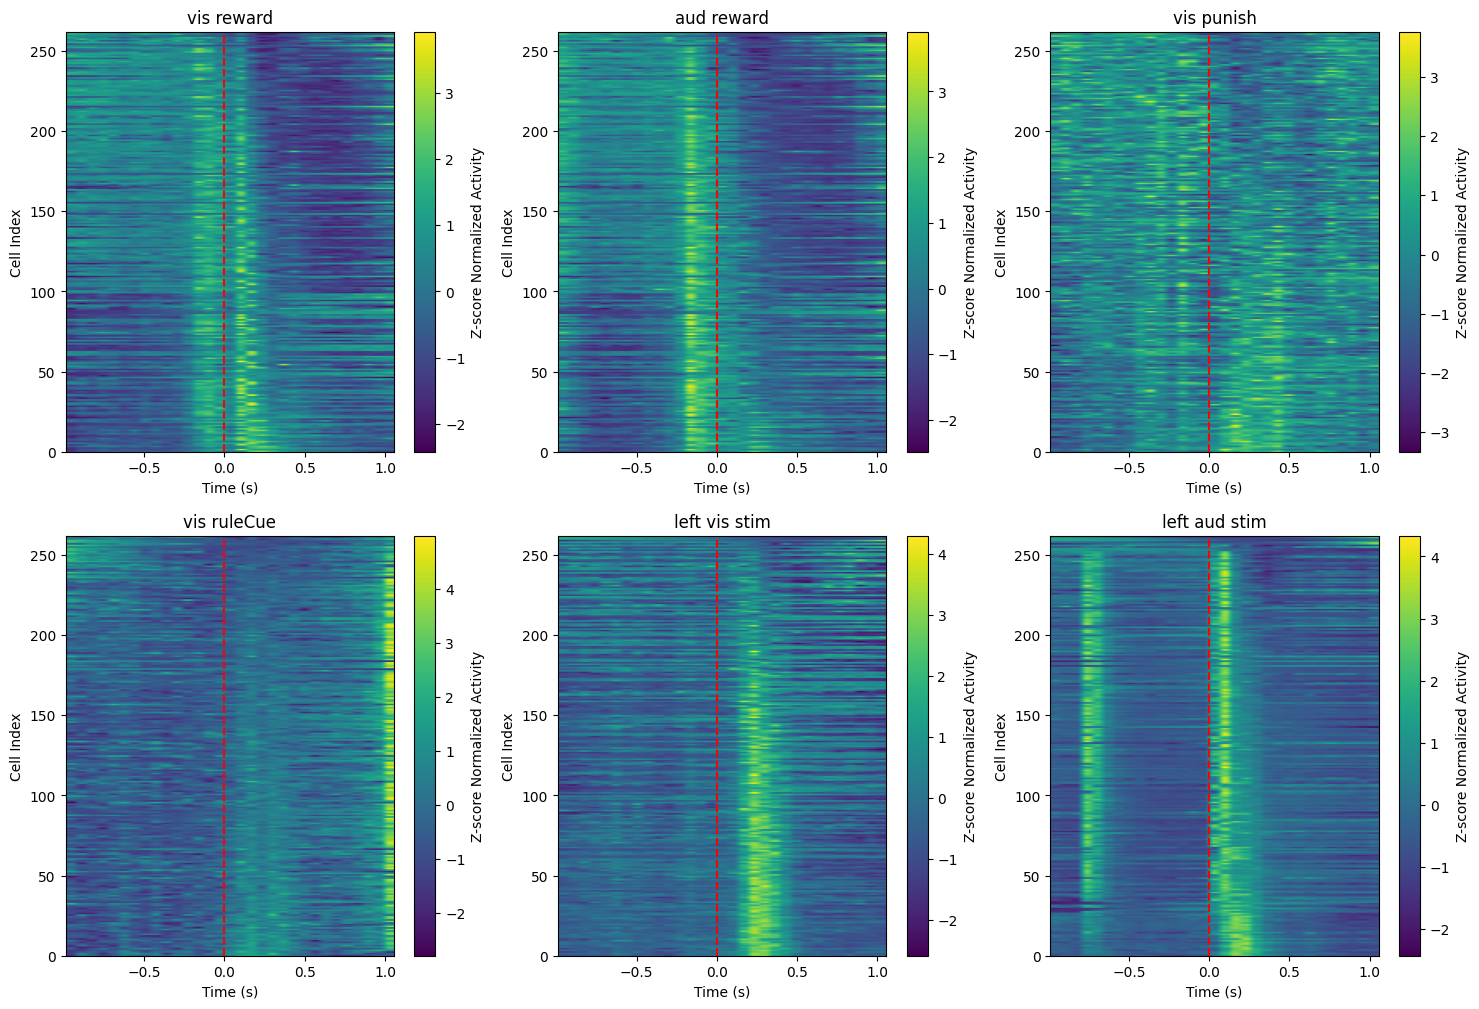

In [81]:
arm1_vis_reward_sort_idx,_ = sort_psth_by_average_response(mean_arm1_vis_reward_psth,0.5,frame_rate_arm1)
arm1_vis_punish_sort_idx,_ = sort_psth_by_average_response(mean_arm1_vis_punish_psth,0.5,frame_rate_arm1)
arm1_vis_ruleCue_sort_idx,_ = sort_psth_by_average_response(mean_arm1_vis_ruleCue_psth,0.5,frame_rate_arm1)
arm1_aud_ruleCue_sort_idx,_ = sort_psth_by_average_response(mean_arm1_aud_ruleCue_psth,0.5,frame_rate_arm1)
arm1_left_vis_stimon_sort_idx,_ = sort_psth_by_average_response(mean_arm1_left_vis_stimOn_psth,0.5,frame_rate_arm1)
arm1_left_aud_stimon_sort_idx,_ = sort_psth_by_average_response(mean_arm1_left_aud_stimOn_psth,0.5,frame_rate_arm1)
arm1_right_aud_stimon_sort_idx,_ = sort_psth_by_average_response(mean_arm1_right_aud_stimOn_psth,0.5,frame_rate_arm1)
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
psth2plot = [mean_arm1_vis_reward_psth[arm1_vis_reward_sort_idx,:],
             mean_arm1_aud_reward_psth[arm1_vis_reward_sort_idx,:], 
             mean_arm1_vis_punish_psth[arm1_vis_punish_sort_idx,:], 
             mean_arm1_vis_ruleCue_psth[arm1_vis_ruleCue_sort_idx,:], 
             mean_arm1_left_vis_stimOn_psth[arm1_left_vis_stimon_sort_idx,:],
             mean_arm1_left_aud_stimOn_psth[arm1_left_aud_stimon_sort_idx,:], 
             ]
titles = ["vis reward", "aud reward", "vis punish", "vis ruleCue", "left vis stim", "left aud stim"]
for ax, mean_psth, title in zip(axs.flat, psth2plot, titles):
    plot_mean_psth(mean_psth, frame_rate_arm1, title, ax)
    # Adding red arrow at time 0
    ax.axvline(x=0, color='red', linestyle='--')

In [77]:
arm1_vis_ruleCue_sort_idx

array([ 76, 126, 216, 190,  92, 228, 168, 218, 226, 222,  83, 120, 206,
        84, 214, 154,  91, 140, 217,  63, 133, 202, 234, 130, 181, 146,
       119, 241, 192, 167, 220, 147, 153,   5, 122, 232, 118, 193,  19,
       210, 223,  80, 249,  61, 150, 231,  75, 169,  57, 143,  93,   1,
        50, 253, 248, 256, 209, 175, 114,  31, 177,  99, 170,  95,  52,
        85, 162,  36, 199, 109, 236, 164, 127,  58,  41, 255, 189, 125,
       124, 179, 158, 207,  44, 196,  77, 260,  11, 128,  38, 224, 165,
       221,  68, 201, 107, 203, 195, 184, 219, 238,  43, 144,  66, 247,
       200, 205,  60, 187, 132, 134, 174, 194, 108, 172,  69,  39, 191,
        22, 102, 211, 135,   7,  46, 257, 152,  55,  28, 180, 198, 142,
       208,  32, 252,  35, 113, 230, 129, 261, 233, 166,  86, 178, 103,
       235,  12, 245,  59, 188,  70,   0,  67, 116, 121,  87,  51, 225,
       138, 176,  14, 117, 149, 259, 258, 244, 112, 239,  54, 186, 157,
        62, 110,  88, 163, 100,  72, 173,  78, 139,   2,  73,  2

In [86]:
p_mask[arm1_left_vis_stimon_sort_idx,unique_predictor_names.index('left_vis_stimOn_times')]

array([False, False,  True,  True, False,  True,  True,  True,  True,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True, False, False, False,  True,
       False,  True,  True, False, False,  True,  True,  True, False,
       False,  True,  True, False, False,  True, False, False,  True,
       False,  True,  True,  True, False,  True,  True,  True,  True,
       False, False,  True, False,  True,  True, False, False, False,
        True, False, False, False,  True,  True, False,  True, False,
        True, False, False,  True, False, False,  True,  True, False,
       False,  True, False,  True,  True,  True,  True, False,  True,
       False, False, False, False, False,  True, False,  True, False,
        True,  True, False, False, False, False, False,  True,  True,
        True, False,  True, False, False,  True,  True,  True,  True,
       False, False,

In [ ]:
plt.figure(figsize=(10,30))
p_mask = arm1_p_corrected<0.05
plt.imshow(p_mask[arm1_left_vis_stimon_sort_idx,unique_predictor_names.index('left_vis_stimOn_times')], origin='lower')

In [ ]:
data = p_mask[arm1_vis_reward_sort_idx, unique_predictor_names.index('vis_reward_times')]

# Reshape the 1D data into a column vector
data_column = data.reshape(-1, 1)
plt.figure(figsize=(5,10))
plt.imshow(data_column, origin='lower', cmap='viridis')

In [32]:
mean_arm1_right_aud_stimOn_psth[0,:].shape

(31,)

In [103]:
vis_ruleCue_kernels_idx = [i for i in range(len(predictor_names)) if 'vis_ruleCue_times' in predictor_names[i]]
aud_ruleCue_kernels_idx = [i for i in range(len(predictor_names)) if 'aud_ruleCue_times' in predictor_names[i]]
left_vis_stimOn_kernels_idx = [i for i in range(len(predictor_names)) if 'left_vis_stimOn_times' in predictor_names[i]]
right_vis_stimOn_kernels_idx = [i for i in range(len(predictor_names)) if 'right_vis_stimOn_times' in predictor_names[i]]
left_aud_stimOn_kernels_idx = [i for i in range(len(predictor_names)) if 'left_aud_stimOn_times' in predictor_names[i]]
right_aud_stimOn_kernels_idx = [i for i in range(len(predictor_names)) if 'right_aud_stimOn_times' in predictor_names[i]]
vis_reward_kernels_idx = [i for i in range(len(predictor_names)) if 'vis_reward_times' in predictor_names[i]]
aud_reward_kernels_idx = [i for i in range(len(predictor_names)) if 'aud_reward_times' in predictor_names[i]]
vis_punish_kernels_idx = [i for i in range(len(predictor_names)) if 'vis_punish_times' in predictor_names[i]]
aud_punish_kernels_idx = [i for i in range(len(predictor_names)) if 'aud_punish_times' in predictor_names[i]]
omission_kernels_idx = [i for i in range(len(predictor_names)) if 'omission_times' in predictor_names[i]]

vis_ruleCue_beta = zscore(beta[:,vis_ruleCue_kernels_idx],axis=1)
aud_ruleCue_beta = zscore(beta[:,aud_ruleCue_kernels_idx],axis=1)
left_vis_stimOn_beta = zscore(beta[:,left_vis_stimOn_kernels_idx],axis=1)
right_vis_stimOn_beta = zscore(beta[:,right_vis_stimOn_kernels_idx],axis=1)
left_aud_stimOn_beta = zscore(beta[:,left_aud_stimOn_kernels_idx],axis=1)
right_aud_stimOn_beta = zscore(beta[:,right_aud_stimOn_kernels_idx],axis=1)
vis_reward_beta = zscore(beta[:,vis_reward_kernels_idx],axis=1)
aud_reward_beta = zscore(beta[:,aud_reward_kernels_idx],axis=1)

vis_punish_beta = zscore(beta[:,vis_punish_kernels_idx],axis=1)
aud_punish_beta = zscore(beta[:,aud_punish_kernels_idx],axis=1)
omission_beta = zscore(beta[:,omission_kernels_idx],axis=1)

In [69]:
vis_ruleCue_beta.shape

(262, 22)

In [108]:
cell_ind2plot = np.arange(64,128)
vis_reward_psth2plot = [mean_arm1_vis_reward_psth[i,:] for i in cell_ind2plot
             ]
vis_reward_beta2plot = [zscore(vis_reward_beta, axis=1)[i,:] for i in cell_ind2plot]

aud_reward_psth2plot = [mean_arm1_aud_reward_psth[i,:] for i in cell_ind2plot
             ]
aud_reward_beta2plot = [zscore(aud_reward_beta, axis=1)[i,:] for i in cell_ind2plot]

vis_punish_psth2plot = [mean_arm1_vis_punish_psth[i,:] for i in cell_ind2plot
             ]
vis_punish_beta2plot = [zscore(vis_punish_beta, axis=1)[i,:] for i in cell_ind2plot]

aud_punish_psth2plot = [mean_arm1_aud_punish_psth[i,:] for i in cell_ind2plot
             ]
aud_punish_beta2plot = [zscore(aud_punish_beta, axis=1)[i,:] for i in cell_ind2plot]

# omission_psth2plot = [mean_arm1_omission_psth[i,:] for i in cell_ind2plot
#              ]
omission_beta2plot = [zscore(omission_beta, axis=1)[i,:] for i in cell_ind2plot]

left_vis_stimOn_psth2plot = [mean_arm1_left_vis_stimOn_psth[i,:] for i in cell_ind2plot
             ]
left_vis_stimOn_beta2plot = [zscore(left_vis_stimOn_beta, axis=1)[i,:] for i in cell_ind2plot] 

right_vis_stimOn_psth2plot = [mean_arm1_right_vis_stimOn_psth[i,:] for i in cell_ind2plot
             ]
right_vis_stimOn_beta2plot = [zscore(right_vis_stimOn_beta, axis=1)[i,:] for i in cell_ind2plot]

left_aud_stimOn_psth2plot = [mean_arm1_left_aud_stimOn_psth[i,:] for i in cell_ind2plot
             ]
left_aud_stimOn_beta2plot = [zscore(left_aud_stimOn_beta, axis=1)[i,:] for i in cell_ind2plot] 

right_aud_stimOn_psth2plot = [mean_arm1_right_aud_stimOn_psth[i,:] for i in cell_ind2plot
             ]
right_aud_stimOn_beta2plot = [zscore(right_aud_stimOn_beta, axis=1)[i,:] for i in cell_ind2plot]

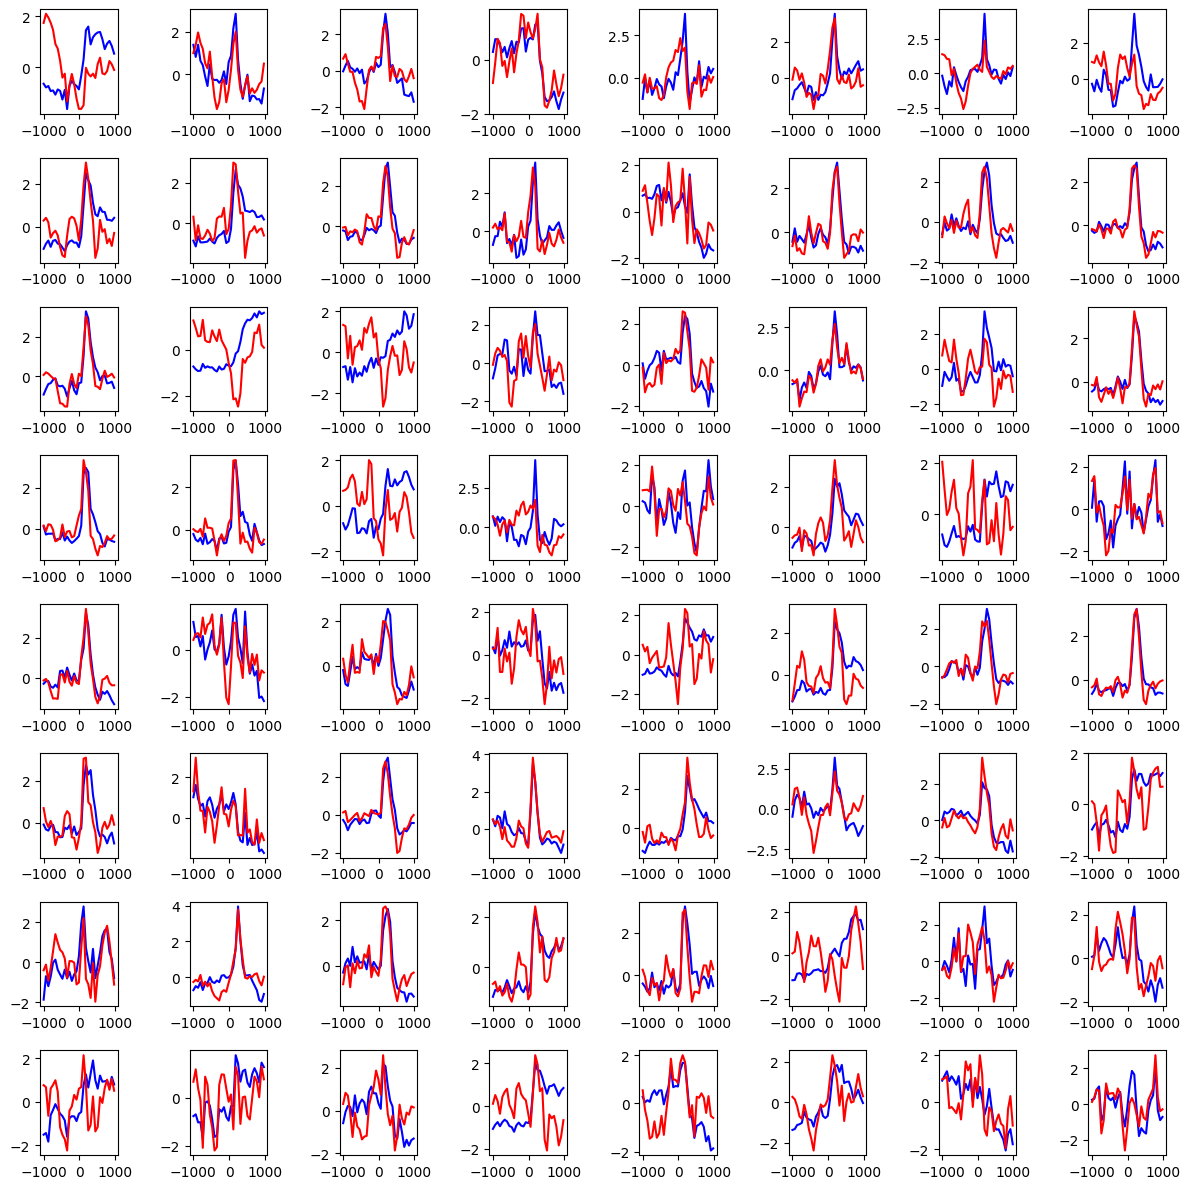

In [110]:
fig, axs = plt.subplots(8, 8, figsize=(12, 12))


titles = ["cell#"+str(arm1_stat[i]['id']) for i in cell_ind2plot]
timepoints = np.arange(-1000,1000,66)
for ax, psth, beta, title in zip(axs.flat, left_vis_stimOn_psth2plot, left_vis_stimOn_beta2plot, titles):
    ax.plot(timepoints,psth,'b')
    ax.plot(timepoints,beta,'r')
plt.tight_layout()

In [12]:
arm1_vis_reward_sort_idx,_ = sort_psth_by_average_response(vis_reward_beta,0.2,frame_rate_arm1)
arm1_vis_punish_sort_idx,_ = sort_psth_by_average_response(vis_punish_beta,0.2,frame_rate_arm1)
arm1_vis_ruleCue_sort_idx,_ = sort_psth_by_average_response(vis_ruleCue_beta,0.2,frame_rate_arm1)
arm1_left_vis_stimon_sort_idx,_ = sort_psth_by_average_response(left_vis_stimOn_beta,0.2,frame_rate_arm1)
arm1_left_aud_stimon_sort_idx,_ = sort_psth_by_average_response(left_aud_stimOn_beta,0.2,frame_rate_arm1)
arm1_right_aud_stimon_sort_idx,_ = sort_psth_by_average_response(right_aud_stimOn_beta,0.2,frame_rate_arm1)
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
psth2plot = [vis_reward_beta[arm1_vis_reward_sort_idx,:],
             aud_reward_beta[arm1_vis_reward_sort_idx,:], 
             vis_punish_beta[arm1_vis_punish_sort_idx,:], 
             aud_ruleCue_beta[arm1_vis_ruleCue_sort_idx,:], 
             left_vis_stimOn_beta[arm1_left_vis_stimon_sort_idx,:],
             left_aud_stimOn_beta[arm1_left_aud_stimon_sort_idx,:], 
             ]
titles = ["vis reward", "aud reward", "vis punish", "vis ruleCue", "left vis stim", "left aud stim"]
for ax, mean_psth, title in zip(axs.flat, psth2plot, titles):
    plot_mean_psth(mean_psth, frame_rate_arm1, title, ax)
    # Adding red arrow at time 0
    ax.axvline(x=0, color='red', linestyle='--')

NameError: name 'vis_reward_beta' is not defined

In [42]:
np.mean(vis_reward_beta)

9.78821355656205e-18

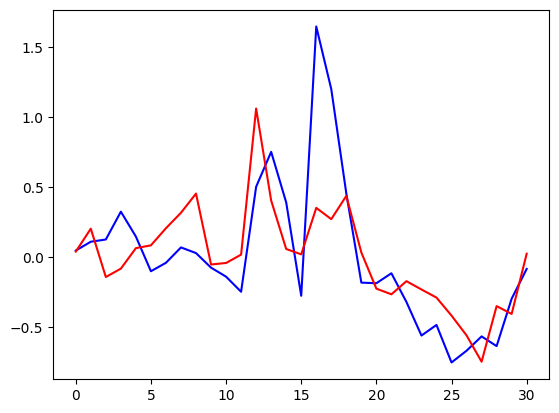

In [23]:
plt.plot(np.mean(vis_reward_beta, axis=0),'b')
plt.plot(np.mean(aud_reward_beta, axis=0),'r')

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
psth2plot = [mean_arm1_vis_reward_psth[arm1_vis_reward_sort_idx,:],
             mean_arm1_aud_reward_psth[arm1_vis_reward_sort_idx,:], 
             mean_arm1_vis_punish_psth[arm1_vis_punish_sort_idx,:], 
             mean_arm1_vis_ruleCue_psth[arm1_vis_ruleCue_sort_idx,:], 
             mean_arm1_left_vis_stimOn_psth[arm1_left_vis_stimon_sort_idx,:],
             mean_arm1_left_aud_stimOn_psth[arm1_left_aud_stimon_sort_idx,:], 
             ]
titles = ["vis reward", "aud reward", "vis punish", "vis ruleCue", "left vis stim", "left aud stim"]
for ax, mean_psth, title in zip(axs.flat, psth2plot, titles):
    plot_mean_psth(mean_psth, frame_rate_arm1, title, ax)
    # Adding red arrow at time 0
    ax.axvline(x=0, color='red', linestyle='--')